# **Project Description**

This project implements a dynamic portfolio optimization strategy using **Deep Reinforcement Learning (DRL)**.

The goal is to train an autonomous trading agent (Policy Network) to sequentially allocate capital among a basket of **15 European assets** (stocks from Italy, Germany, and France) and a **CASH** reserve, aiming to maximize long-term logarithmic return while simultaneously enforcing portfolio diversification.

## **Methodology**

1.  **DRL Agent (Actor Network):**

A Convolutional Neural Network (CNN/Conv1D) serves as the Policy Network.

It processes a 50-day lookback window of technical indicators (including SMA, RSI, and MACD) to model the market state ($S_t$) and outputs a normalized vector of portfolio weights ($\omega_{t+1}$).

2.  **Custom Loss Function:**

The model is trained using a customized loss function that maximizes the portfolio's average log-return and includes an explicit **diversification penalty** (based on the Herfindahl-Hirschman Index, HHI).

This formulation is designed to create a more robust and risk-managed trading strategy that avoids excessive concentration in a few assets.

3.  **Evaluation:**

The DRL agent’s performance is rigorously tested on a held-out data set from 2019 to 2025 and benchmarked against traditional passive strategies: **Buy & Hold (B&H)** and an **Equal-Weight (EW) Portfolio**.

**Warning**:

This notebook is not a financial advisor.

In [3]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=95d39cc0f0f69237ec6fb00aaa23b0583653410ccf556c15f2a0349097666de7
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
import ta
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, Flatten, Softmax, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')


[****************      33%                       ]  5 of 15 completed

[*********************100%***********************]  15 of 15 completed


Successfully downloaded data for 15 assets.
Preprocessing data and adding technical indicators...
Created X (states) with shape: (1477, 50, 60)
Created y (targets) with shape: (1477, 16)
Train samples: 1181, CV samples: 148, Test samples: 148

--- Policy Network (Actor) Summary ---


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ State_Input (InputLayer)        │ (None, 50, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 48, 32)         │         5,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 48, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 48, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 46, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 46, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2944)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       376,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Raw_Logits (Dense)              │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Portfolio_Weights_omega_t       │ (None, 16)             │             0 │
│ (Softmax)                       │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 391,408 (1.49 MB)

 Trainable params: 391,216 (1.49 MB)

 Non-trainable params: 192 (768.00 B)


--- Starting Training for 100 Epochs ---
Epoch 1/100 | Train Loss (R + Div): 0.085554 | CV Reward (R): 0.000258
  -> New best model found with CV Reward: 0.000258
Epoch 2/100 | Train Loss (R + Div): 0.085849 | CV Reward (R): 0.000285
  -> New best model found with CV Reward: 0.000285
Epoch 3/100 | Train Loss (R + Div): 0.085961 | CV Reward (R): 0.000278
Epoch 4/100 | Train Loss (R + Div): 0.085012 | CV Reward (R): 0.000236
Epoch 5/100 | Train Loss (R + Div): 0.086793 | CV Reward (R): 0.000159
Epoch 6/100 | Train Loss (R + Div): 0.085438 | CV Reward (R): 0.000074
Epoch 7/100 | Train Loss (R + Div): 0.084670 | CV Reward (R): 0.000017
Epoch 8/100 | Train Loss (R + Div): 0.085877 | CV Reward (R): -0.000014
Epoch 9/100 | Train Loss (R + Div): 0.086509 | CV Reward (R): -0.000032
Epoch 10/100 | Train Loss (R + Div): 0.085061 | CV Reward (R): -0.000051
Epoch 11/100 | Train Loss (R + Div): 0.085404 | CV Reward (R): -0.000064
Epoch 12/100 | Train Loss (R + Div): 0.086344 | CV Reward (R): -0.000

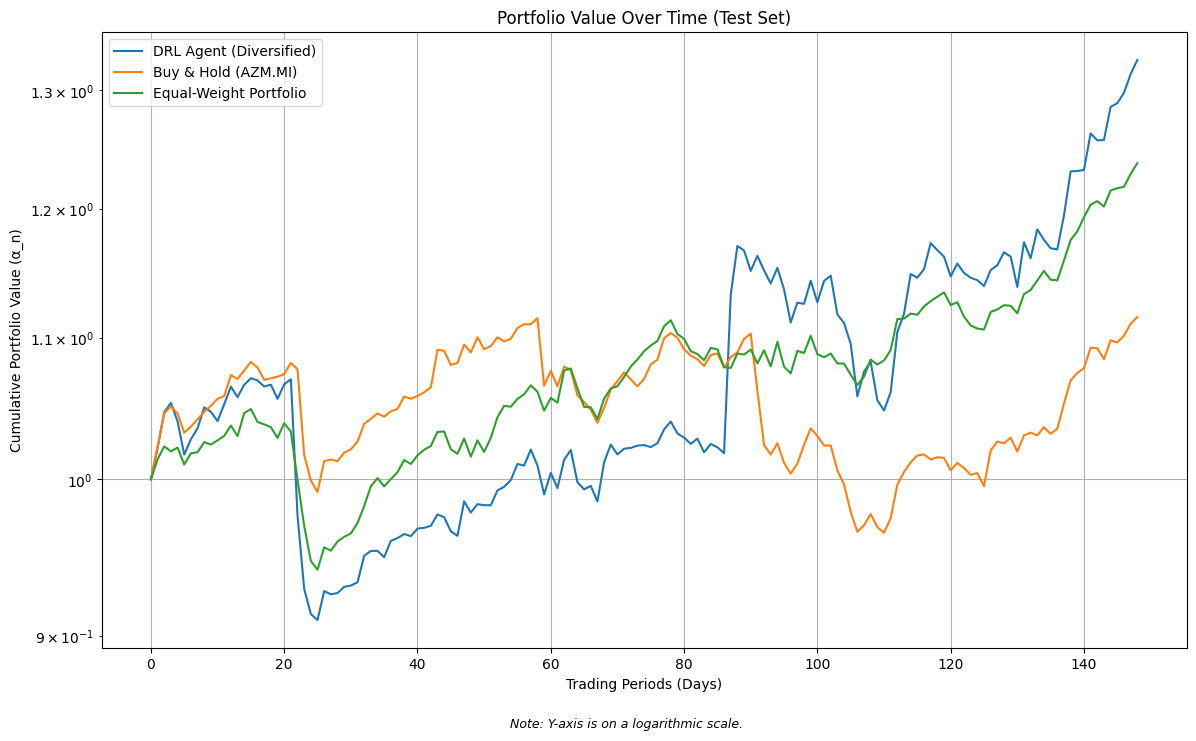

In [15]:

TICKERS = [
    "AZM.MI", "BAMI.MI", "BGN.MI", "BMED.MI", "BPE.MI",
    "ALV.DE", "CBK.DE", "DBK.DE", "DB1.DE", "DTE.DE",
    "BNP.PA", "CS.PA", "GLE.PA", "ACA.PA", "CAP.PA"
]

ASSETS = ["CASH"] + TICKERS
NUM_ASSETS = len(ASSETS)


START_DATE = "2019-01-01"
END_DATE = "2025-01-31"


LOOKBACK_WINDOW = 50
L2_REG_COEFF = 1e-8
DROPOUT_RATE = 0.7
INIT_STDDEV = 0.1
LEARNING_RATE = 1e-5
EPOCHS = 100
BATCH_SIZE = 64


DIVERSIFICATION_COEFFICIENT = 0.1

def download_data(tickers, start, end):

    print(f"Downloading data for {len(tickers)} tickers from {start} to {end}...")
    try:
        data = yf.download(tickers, start=start, end=end)['Close']

        data = data.ffill().dropna()


        downloaded_tickers = data.columns.tolist()
        missing = [t for t in tickers if t not in downloaded_tickers]
        if missing:
            print(f"Warning: Could not download data for: {missing}")

            data = data.drop(columns=missing)
            global TICKERS, ASSETS, NUM_ASSETS
            TICKERS = [t for t in TICKERS if t not in missing]
            ASSETS = ["CASH"] + TICKERS
            NUM_ASSETS = len(ASSETS)

        print(f"Successfully downloaded data for {len(TICKERS)} assets.")
        return data
    except Exception as e:
        print(f"Error downloading data: {e}")
        return pd.DataFrame()

def preprocess_data(price_df, lookback_window):

    print("Preprocessing data and adding technical indicators...")


    price_relatives = price_df.pct_change().dropna() + 1.0


    price_relatives.insert(0, 'CASH', 1.0)


    features = pd.DataFrame(index=price_df.index)
    for ticker in price_df.columns:

        features[f'{ticker}_SMA_20'] = ta.trend.sma_indicator(price_df[ticker], window=20)

        features[f'{ticker}_RSI_14'] = ta.momentum.rsi(price_df[ticker], window=14)

        features[f'{ticker}_MACD'] = ta.trend.macd_diff(price_df[ticker], window_slow=26, window_fast=12, window_sign=9)

        features[f'{ticker}_REL_PRICE'] = price_df[ticker].pct_change() + 1.0


    features = features.dropna()


    common_index = features.index.intersection(price_relatives.index)
    features = features.loc[common_index]
    y = price_relatives.loc[common_index].values


    X_list = []
    y_list = []


    for t in range(lookback_window - 1, len(features) - 1):

        X_t = features.iloc[t - lookback_window + 1 : t + 1].values
        X_list.append(X_t)


        y_t_plus_1 = y[t]
        y_list.append(y_t_plus_1)

    X = np.array(X_list)
    y = np.array(y_list)

    print(f"Created X (states) with shape: {X.shape}")
    print(f"Created y (targets) with shape: {y.shape}")

    return X, y

def split_and_scale_data(X, y):

    n_samples = X.shape[0]


    train_end = int(n_samples * 0.8)
    cv_end = int(n_samples * 0.9)


    X_train, y_train = X[:train_end], y[:train_end]
    X_cv, y_cv = X[train_end:cv_end], y[train_end:cv_end]
    X_test, y_test = X[cv_end:], y[cv_end:]

    print(f"Train samples: {len(X_train)}, CV samples: {len(X_cv)}, Test samples: {len(X_test)}")


    n_features = X.shape[2]
    X_train_reshaped = X_train.reshape(-1, n_features)


    scaler = StandardScaler()
    scaler.fit(X_train_reshaped)


    X_train_norm = scaler.transform(X_train_reshaped).reshape(X_train.shape)

    X_cv_reshaped = X_cv.reshape(-1, n_features)
    X_cv_norm = scaler.transform(X_cv_reshaped).reshape(X_cv.shape)

    X_test_reshaped = X_test.reshape(-1, n_features)
    X_test_norm = scaler.transform(X_test_reshaped).reshape(X_test.shape)

    return (X_train_norm, y_train), (X_cv_norm, y_cv), (X_test_norm, y_test)




def build_policy_network(input_shape, num_assets, l2_reg, dropout_rate, init_stddev):

    initializer = RandomNormal(mean=0.0, stddev=init_stddev)

    state_input = Input(shape=input_shape, name="State_Input")

    x = Conv1D(filters=32, kernel_size=3, activation='relu',
               kernel_initializer=initializer,
               kernel_regularizer=l2(l2_reg))(state_input)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Conv1D(filters=64, kernel_size=3, activation='relu',
               kernel_initializer=initializer,
               kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Flatten()(x)

    x = Dense(128, activation='relu',
              kernel_initializer=initializer,
              kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)



    raw_output = Dense(num_assets, activation='linear',
                       kernel_initializer=initializer,
                       name="Raw_Logits")(x)

    portfolio_weights = Softmax(name="Portfolio_Weights_omega_t")(raw_output)

    model = Model(inputs=state_input, outputs=portfolio_weights)
    return model

def custom_loss(y_true, y_pred):



    portfolio_return = tf.reduce_sum(y_pred * y_true, axis=1)


    log_return = tf.math.log(portfolio_return + 1e-9)


    loss_reward = -tf.reduce_mean(log_return)


    concentration = tf.reduce_sum(tf.square(y_pred), axis=1)
    loss_diversification = tf.reduce_mean(concentration)


    total_loss = loss_reward + (DIVERSIFICATION_COEFFICIENT * loss_diversification)

    return total_loss




def run_backtest(model, X_data, y_data, initial_capital=1.0):

    capital = initial_capital


    omega = np.zeros(NUM_ASSETS)
    omega[0] = 1.0

    capital_history = [capital]
    weights_history = [omega]

    for t in range(len(X_data)):

        state_t = np.expand_dims(X_data[t], axis=0)


        omega = model.predict(state_t, verbose=0)[0]


        y_t_plus_1 = y_data[t]


        r_t_plus_1 = np.dot(omega, y_t_plus_1)


        capital = capital * r_t_plus_1


        capital_history.append(capital)
        weights_history.append(omega)

    capital_series = pd.Series(capital_history)
    returns = capital_series.pct_change().dropna()

    return capital_series, returns, np.array(weights_history)

def calculate_metrics(capital_history, returns):

    print("-" * 30)


    final_capital = capital_history.iloc[-1]
    print(f"Final Portfolio Value (α_n): {final_capital:.4f}")


    std_dev = returns.std()
    print(f"Standard Deviation (σ_p):   {std_dev:.6f}")


    mean_return = returns.mean()
    sharpe_ratio = mean_return / (std_dev + 1e-9)
    print(f"Sharpe Ratio (S):           {sharpe_ratio:.4f}")


    running_max = capital_history.cummax()
    drawdown = (capital_history - running_max) / running_max
    mdd = drawdown.min()
    print(f"Maximum Drawdown (MDD):     {mdd:.4f}")
    print("-" * 30)

    return final_capital, std_dev, sharpe_ratio, mdd

def run_baseline_strategies(y_data, initial_capital=1.0):

    n_periods = y_data.shape[0]


    bh_omega = np.zeros(NUM_ASSETS)
    bh_omega[1] = 1.0

    bh_capital = initial_capital
    bh_history = [bh_capital]
    for t in range(n_periods):
        r_t = np.dot(bh_omega, y_data[t])
        bh_capital *= r_t
        bh_history.append(bh_capital)

    bh_capital_series = pd.Series(bh_history)
    bh_returns = bh_capital_series.pct_change().dropna()


    ew_omega = np.ones(NUM_ASSETS)
    ew_omega[0] = 0.0
    ew_omega[1:] = 1.0 / (NUM_ASSETS - 1)

    ew_capital = initial_capital
    ew_history = [ew_capital]
    for t in range(n_periods):
        r_t = np.dot(ew_omega, y_data[t])
        ew_capital *= r_t
        ew_history.append(ew_capital)

    ew_capital_series = pd.Series(ew_history)
    ew_returns = ew_capital_series.pct_change().dropna()

    return (bh_capital_series, bh_returns), (ew_capital_series, ew_returns)




def main():

    price_data = download_data(TICKERS, START_DATE, END_DATE)
    if price_data.empty:
        return

    X, y = preprocess_data(price_data, LOOKBACK_WINDOW)
    (X_train, y_train), (X_cv, y_cv), (X_test, y_test) = split_and_scale_data(X, y)


    input_shape = (LOOKBACK_WINDOW, X.shape[2])

    model = build_policy_network(
        input_shape=input_shape,
        num_assets=NUM_ASSETS,
        l2_reg=L2_REG_COEFF,
        dropout_rate=DROPOUT_RATE,
        init_stddev=INIT_STDDEV
    )

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss=custom_loss
    )

    print("\n--- Policy Network (Actor) Summary ---")
    model.summary()


    print(f"\n--- Starting Training for {EPOCHS} Epochs ---")

    best_cv_reward = -np.inf
    best_model_weights = None

    for epoch in range(EPOCHS):

        history = model.fit(
            X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=1,
            shuffle=True,
            validation_data=(X_cv, y_cv),
            verbose=0
        )


        train_loss = history.history['loss'][0]


        cv_cap, cv_returns, _ = run_backtest(model, X_cv, y_cv)


        cv_portfolio_returns = cv_returns + 1.0
        cv_reward = np.mean(np.log(cv_portfolio_returns + 1e-9))

        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss (R + Div): {train_loss:.6f} | CV Reward (R): {cv_reward:.6f}")


        if cv_reward > best_cv_reward:
            best_cv_reward = cv_reward
            best_model_weights = model.get_weights()
            print(f"  -> New best model found with CV Reward: {best_cv_reward:.6f}")


    if best_model_weights:
        model.set_weights(best_model_weights)
        print("\nLoaded best model weights (from CV set).")
    else:
        print("\nWarning: No best model found. Using last model weights.")


    print("\n--- Final Performance Evaluation on Test Set  ---")


    print("\n[DRL Agent (Diversified) Performance]")
    drl_cap, drl_returns, drl_weights = run_backtest(model, X_test, y_test)
    calculate_metrics(drl_cap, drl_returns)


    (bh_cap, bh_returns), (ew_cap, ew_returns) = run_baseline_strategies(y_test)

    print("\n[Buy & Hold (1st Ticker) Performance]")
    calculate_metrics(bh_cap, bh_returns)

    print("\n[Equal-Weight (EW) Performance]")
    calculate_metrics(ew_cap, ew_returns)


    plt.figure(figsize=(14, 8))
    plt.plot(drl_cap, label="DRL Agent (Diversified)")
    plt.plot(bh_cap, label=f"Buy & Hold ({TICKERS[0]})")
    plt.plot(ew_cap, label="Equal-Weight Portfolio")

    plt.title("Portfolio Value Over Time (Test Set)")
    plt.xlabel("Trading Periods (Days)")
    plt.ylabel("Cumulative Portfolio Value (α_n)")
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.figtext(0.5, 0.01, "Note: Y-axis is on a logarithmic scale.",
                ha="center", fontsize=9, style='italic')
    plt.show()



if __name__ == "__main__":
    main()